# Model Tuning

Author: Valentina Staneva

This notebook discusses techniques to improve the performance of a model: particularly in the case where we do not have a lot of training data and the models can be prone to overfitting. It covers several strategies:

* Dropout
* Data Augmentation
* Tranfer Learning

Along the way we will also go through details on

* Optimization
* Monitoring Performance
* Loading and Saving Models

This notebook is built on these sources:

* [*Tensorflow Classification Tutorial*](https://www.tensorflow.org/tutorials/images/classification)

* [*Transfer Learning with VGG16 and Keras*](https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4),  Medium Blog Post by Gabriel Cassimiro

* [*Tensorflow Transfer Learning Tutorial*](https://www.tensorflow.org/tutorials/images/transfer_learning)

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# set random seed
# tf.keras.utils.set_random_seed(123)

In [3]:
# set random seed
# tf.keras.utils.set_random_seed(123)
# tf.random.set_seed(123)

## Flowers Dataset

This tutorial uses a [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) of about 3,700 photos of flowers. The dataset contains five types of flowers:

```
  daisy
  dandelion
  roses
  sunflowers
  tulips
```

The goal is to build a classifier which predicts the type of flowers in new images.

The dataset is part of a collection of [datasets](https://www.tensorflow.org/datasets) in the `tensorflow` library which can be directly loaded.

In [4]:
# downloading images

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')
print(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

/Users/jlheller/.keras/datasets/flower_photos_extracted
0


In [5]:
ls /root/.keras/datasets/flower_photos_extracted/flower_photos

ls: /root/.keras/datasets/flower_photos_extracted/flower_photos: No such file or directory


In [6]:
# the images are arranged in folders with their names
import os
list(os.walk(data_dir))[0]

('/Users/jlheller/.keras/datasets/flower_photos_extracted',
 ['flower_photos'],
 [])

[PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/100930342_92e8746431_n.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/10094729603_eeca3f2cb6.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/10094731133_94a942463c.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/10128546863_8de70c610d.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/10163955604_ae0b830975_n.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/10164073235_f29931d91e.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/10686568196_b1915544a8.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_photos_extracted/flower_photos/tulips/107693873_86021ac4ea_n.jpg'), PosixPath('/Users/jlheller/.keras/datasets/flower_pho

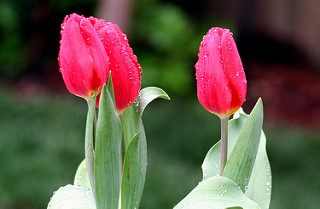

In [7]:
# looking at a few tulips
tulips = list(sorted(data_dir.glob('flower_photos/tulips/*')))
print(tulips)
PIL.Image.open(str(tulips[0]))

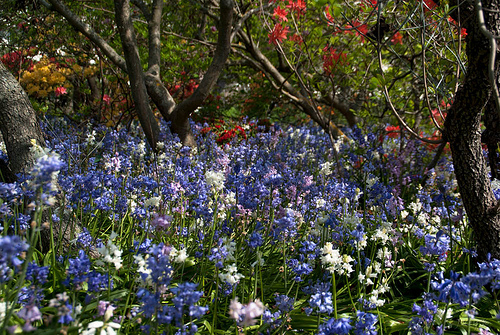

In [8]:
PIL.Image.open(str(tulips[1]))

#### Images are not the same size!

The images in the dataset are not the same size so we will resize them so that it is easier to put them in an array and process them efficiently. We fix the weight and height to be 150. This resizing can be achieved automatically while reading the data with the `tf.keras.utils.image_dataset_from_directory` function and setting the image size.

In [9]:
HEIGHT = 150
WIDTH = 150

In [10]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "flower_photos",
  validation_split=0.2,
  subset="both",
  labels="inferred",
  label_mode="categorical",
  seed=123,
  image_size=(HEIGHT, WIDTH),
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


**Note:** if resizing images in your dataset, you need to select an approach which does not distort substantially your data. The `tf.keras.utils.image_dataset_from_directory` function has some other options such as cropping or padding to aspect ratio.





In [11]:
help(tf.keras.utils.image_dataset_from_directory)

Help on function image_dataset_from_directory in module keras.src.utils.image_dataset_utils:

image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, pad_to_aspect_ratio=False, data_format=None, verbose=True)
    Generates a `tf.data.Dataset` from image files in a directory.
    
    If your directory structure is:
    
    ```
    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
    ```
    
    Then calling `image_dataset_from_directory(main_directory,
    labels='inferred')` will return a `tf.data.Dataset` that yields batches of
    images from the subdirectories `class_a` and `class_b`, together with labels
    0 and 1 (0 corresponding to `class_a` and 1 correspo

### Hold Out Test Set
Not we set aside 20% for a test set which we will NOT use in model training and selection. It is easy to overtune the model performance to the specific test we have selected and because we have no more "unseen" data to test on our measures of performance may be skewed. We will only use the test set in the end to evaluate the performance on "unseen" data.

In [12]:
# convert to numpy arrays
train_images, train_labels = zip(*list(train_ds.unbatch()))
train_images = np.array(train_images)
train_labels = np.array(train_labels)

2025-10-29 13:16:55.160814: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
list(train_ds.unbatch())[1][1]

2025-10-29 13:16:55.936292: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 1., 0.], dtype=float32)>

In [14]:
print(train_images.shape)
print(train_labels.shape)

(2936, 150, 150, 3)
(2936, 5)


We loaded the labels in a categorical format, but we also need the class names. These correspond to the directory names in alphabetical order.

In [15]:
class_names = ["daisy", "dandelion", "roses", "sunflowers","tulips"]
num_classes = len(class_names)

Let's see the distribution of the classes:

<BarContainer object of 5 artists>

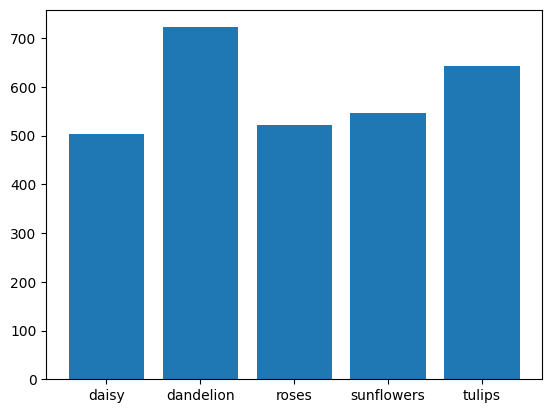

In [16]:
plt.bar(class_names, train_labels.sum(axis=0))

### Visualize the data



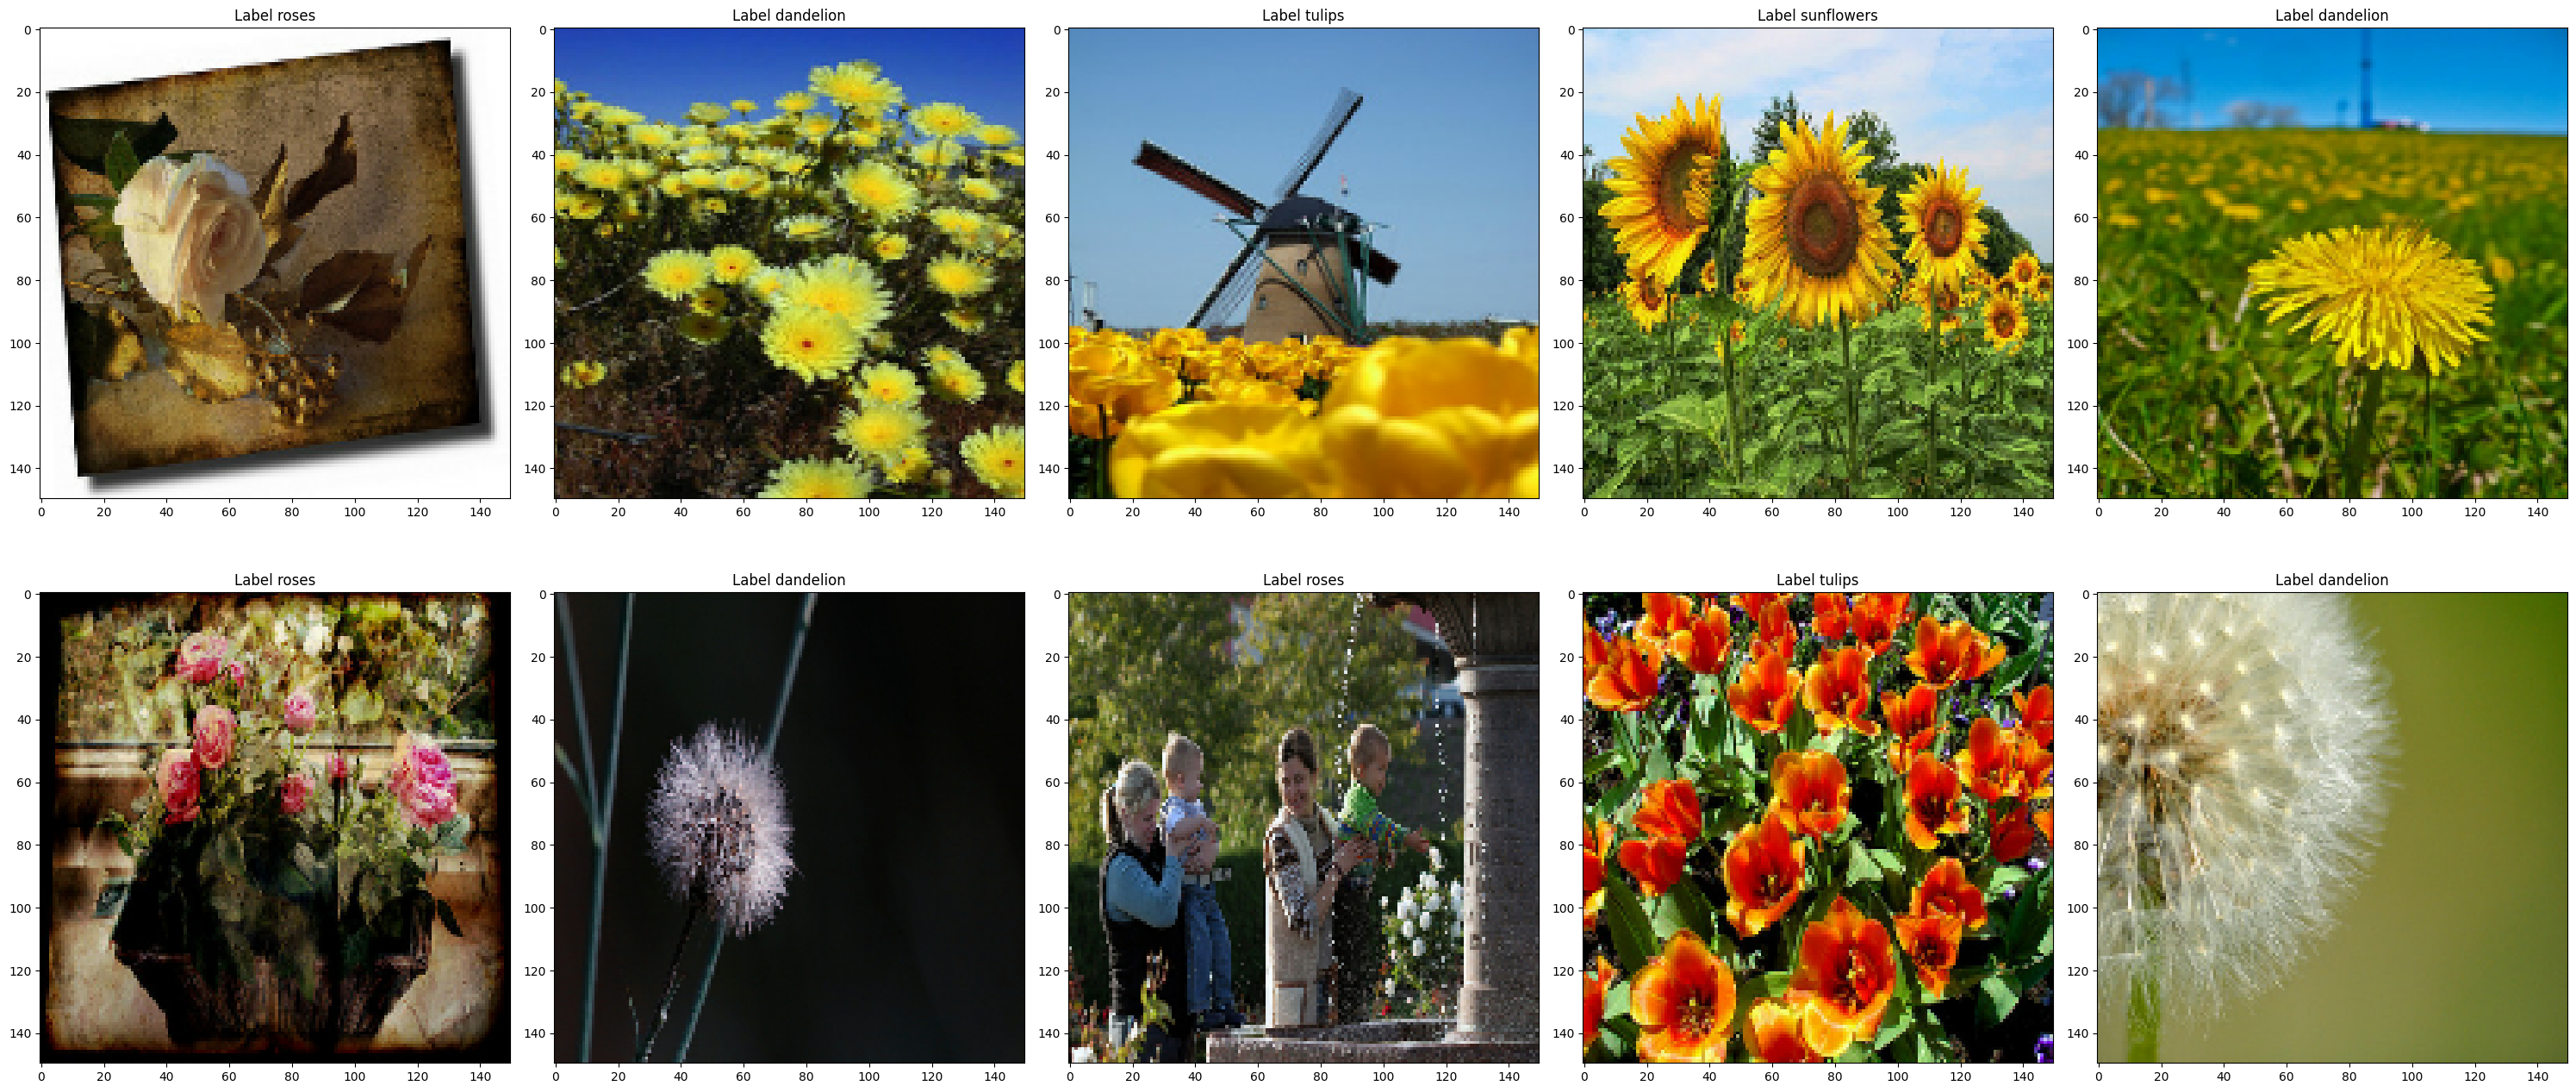

In [17]:
plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True

counter = 0
for image, label in zip(train_images, train_labels):
  plt.subplot(2, 5, counter+1)
  plt.imshow(image.astype("uint8"))
  label_name = class_names[np.where(label==1)[0][0]]
  plt.title('Label {}'.format(label_name))
  counter += 1
  if counter == 10:
    break

### Rescale the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

We can rescale values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling` in the model definition itself.

In [18]:
layers.Rescaling(1./255)

<Rescaling name=rescaling, built=False>

## A Basic CNN Model



### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [19]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

/Users/jlheller/home/Technical/repos/pixel_proficiency/pix/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `categorical_crossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

One can pass other built-in metrics or pass their own metric function.

**Exercise:** pass other [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) and run the plot below. Modify the plots to visualize the other metrics.

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,565 (10.22 MB)

 Trainable params: 2,678,565 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

* minimize **loss** on **training** dataset
* monitor **metrics** on **validation** dataset

![](https://drive.google.com/uc?export=view&id=1AH3JCmgoFGD_3AqyG8M9SNZ29040RVtL)

**Loss**
* $\theta $ - model parameters (weights)
* $L_\theta (\{x_i, y_i\})$ - comparing model predictions $f_{\theta}(x_i)$ with observations $y_i$
  * Mean Squared Error for regression: $\sum_i (f_{\theta}(x_i)-y_i)^2$
  * Categorical Cross Entropy for classification: $-\sum_i \sum_c y_{ic} \log(f_{\theta}(x_i)_c)$

**Gradient Descent**

* $\theta_{t+1} = \theta_t - \alpha\nabla_\theta L_{\theta}(\underbrace{\{x_i,y_i\}}_{\textrm{all observations}})$
* $\alpha$ - learning rate (step size)
* decreases loss at each step (unless gradient is zero)
* requires calculating a gradient over the whole dataset


**Stochastic Gradient Descent**

* $\theta_{t+1} = \theta_t - \alpha\nabla_\theta L_{\theta}(\underbrace{\{x_i,y_i\}}_{\textrm{single random observation}})$

* eventually decreases loss (could be jumpy)
* cheap gradient calculation



**Mini-batch Gradient Descent**

* $\theta_{t+1} = \theta_t - \alpha\nabla_\theta L_{\theta}(\underbrace{\{x_i,y_i\}}_{\textrm{random batch of obsevations}})$

* compromise!


**Iteration:** the weights are updated based on a new batch

**Epoch:** the algorithm iterates over all batches (full training dataset)

![epochs_image](https://drive.google.com/uc?export=view&id=1Yd_l-z-PGCr7v0EwEyCWzcWBG_BoLZsX)

Image Source: [Thanapol et. al. ](https://www.mdpi.com/2076-3417/14/6/2349)

Mini-batch stochastic gradient descent is critical in being able to train huge networks on large datasets since we never have to load the whole dataset at one time! **Batch size** should allow to fit individual batch into memory and have sample big enough so weight updates and validation metrics are not too noisy.

**Early Stopping:** We set the max number of epochs to 50 in the `Model.fit` method, but we will also set an early stopping criterion which will monitor how the algorithm performs on the validation set, and if there is no significant improvement, the algorithm will stop.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [23]:
train_labels.shape

(2936, 5)

In [24]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.3803 - loss: 1.3867 - val_accuracy: 0.4830 - val_loss: 1.3157
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5277 - loss: 1.1522 - val_accuracy: 0.4813 - val_loss: 1.2698
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5690 - loss: 1.1037 - val_accuracy: 0.4711 - val_loss: 1.2659
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5950 - loss: 1.0371 - val_accuracy: 0.4167 - val_loss: 1.3361
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5907 - loss: 1.0386 - val_accuracy: 0.4456 - val_loss: 1.3997
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5945 - loss: 1.0647 - val_accuracy: 0.4847 - val_loss: 1.2731
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.5865 - loss: 1.0649 - val_accuracy: 0.5187 - val_loss: 1.3075
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.6158 - loss: 0.9853 - val_accu

**Warning!** If you run the fit command twice the model will continue to update the existing model, unless you rerun the model definition command.

We observe that

* the training set accuracy is almost 1
* the validation set accuracy is around ~0.63.

### Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [25]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

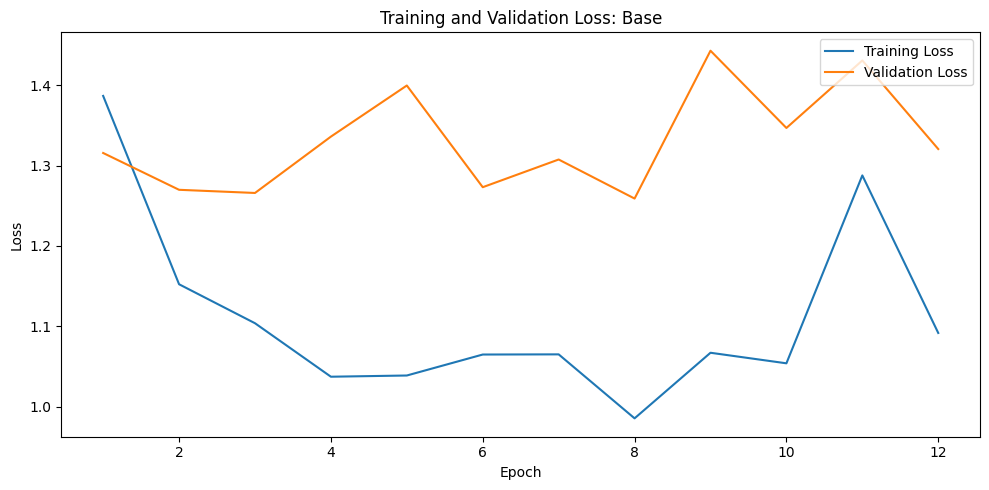

Text(0, 0.5, 'Accuracy')

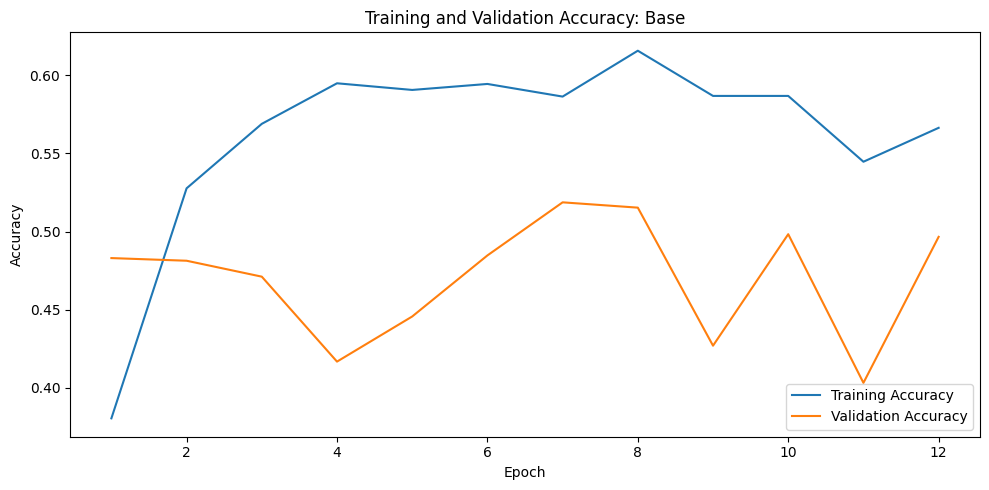

In [26]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Base')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Base')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.


### Overfitting!

## Dropout

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process and we will discuss those below.



Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

![image](https://raw.githubusercontent.com/mohcinemadkour/mohcinemadkour.github.io/master/images/dropout/1.gif)

Image from [mohcinemadkour.github.io](https://mohcinemadkour.github.io/posts/2020/04/Deep%20Learning%20Regularization/)



Create a new neural network with `tf.keras.layers.Dropout`.

In [27]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [28]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.2802 - loss: 1.6772 - val_accuracy: 0.2194 - val_loss: 1.6015
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.3531 - loss: 1.4918 - val_accuracy: 0.2245 - val_loss: 1.6497
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.4195 - loss: 1.3265 - val_accuracy: 0.2262 - val_loss: 1.7391
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.4519 - loss: 1.2492 - val_accuracy: 0.2381 - val_loss: 1.8278
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.4744 - loss: 1.2184 - val_accuracy: 0.2500 - val_loss: 1.9231
CPU times: user 3.81 s, sys: 1.06 s, total: 4.87 s
Wall time: 50.6 s


In [30]:
train_labels.shape

(2936, 5)

* The trainining accuracy is lower!

* The validation accuracy ~ 67%.

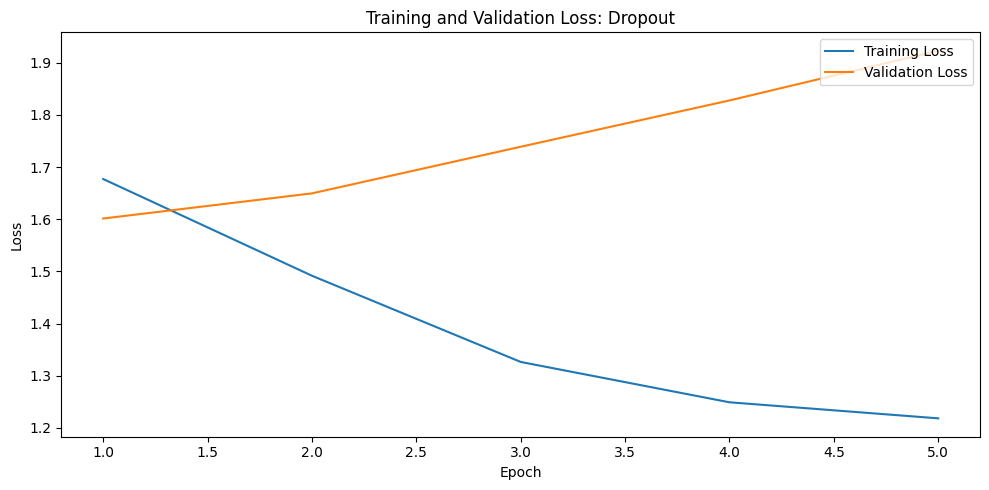

Text(0, 0.5, 'Accuracy')

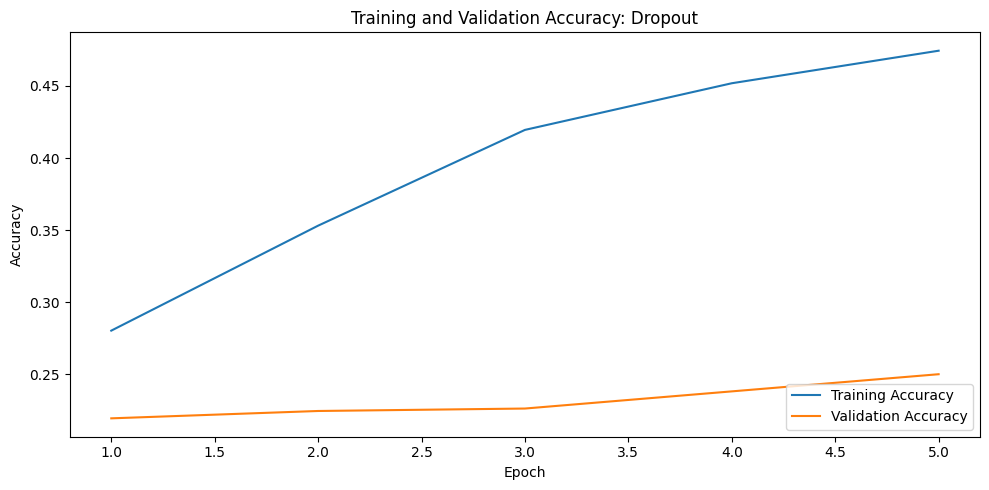

In [31]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Dropout')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Another approach to address overfitting is to add a weight regularizer (like in Ridge and Lasso Regression):(https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1)


In [32]:
tf.keras.regularizers.L1(
    l1=0.01
)

**Exercise:** try an L1 or L2 regularizers to the trainings and evaluate performance.

## Data Augmentation

[Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

Visualize a few augmented examples by applying data augmentation to the same image several times:

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=train_images[0,:,:,:].shape),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

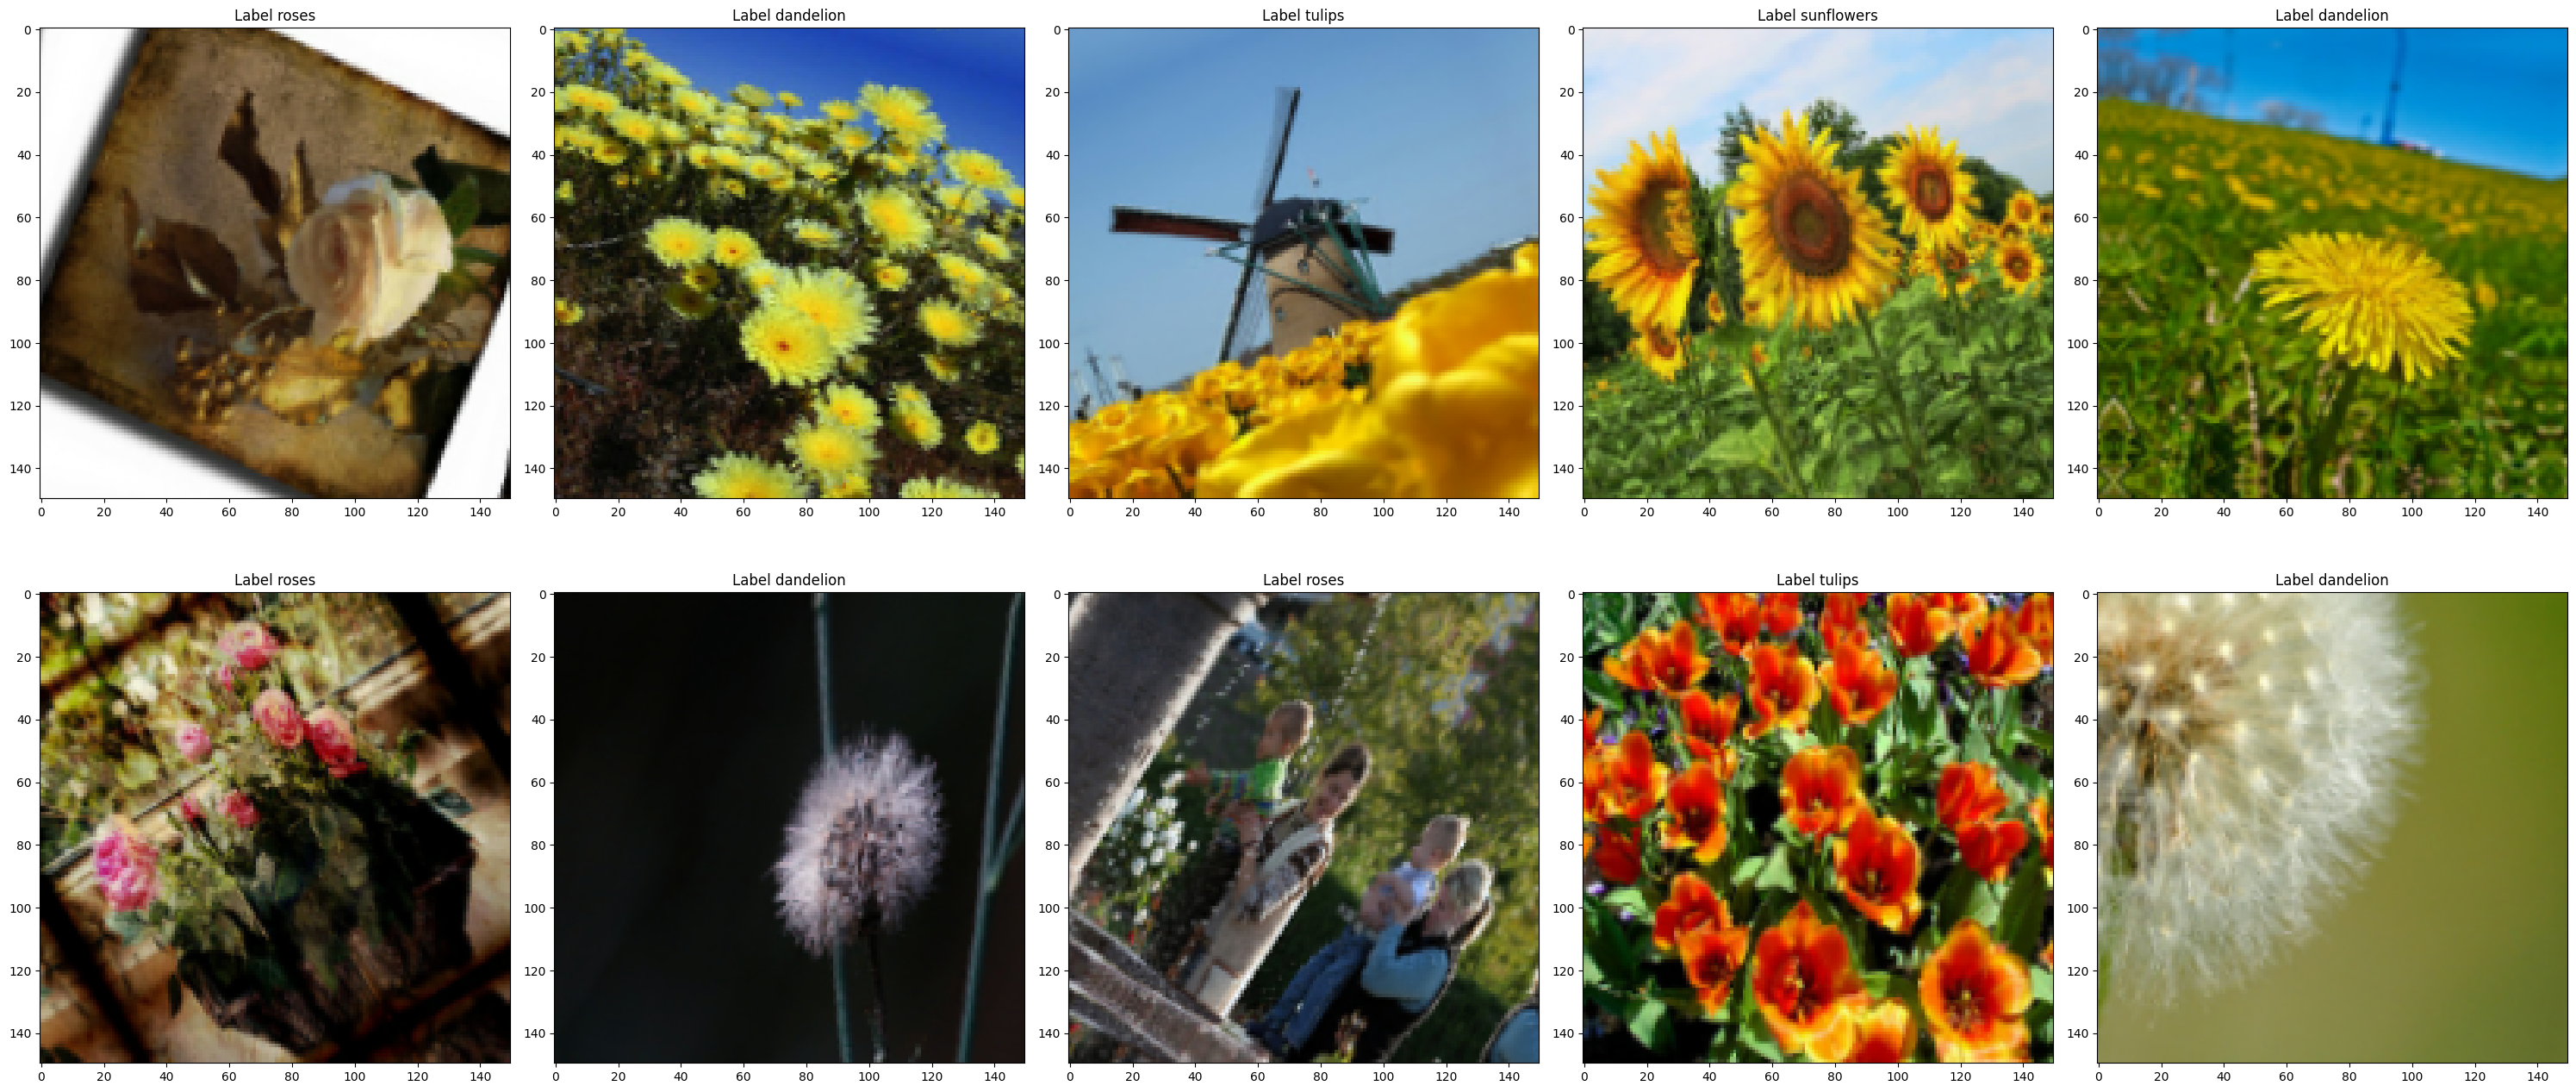

In [34]:
plt.rcParams["figure.figsize"] = [30, 15]
plt.rcParams["figure.autolayout"] = True

counter = 0
for image, label in zip(train_images, train_labels):
  plt.subplot(2, 5, counter+1)
  plt.imshow(data_augmentation(np.reshape(image, (1, HEIGHT, WIDTH, 3))).cpu().numpy().astype('uint8').squeeze())
  label_name = class_names[np.where(label==1)[0][0]]
  plt.title('Label {}'.format(label_name))
  counter += 1
  if counter == 10:
    break

In [35]:
help(layers.RandomRotation)

Help on class RandomRotation in module keras.src.layers.preprocessing.image_preprocessing.random_rotation:

class RandomRotation(keras.src.layers.preprocessing.image_preprocessing.base_image_preprocessing_layer.BaseImagePreprocessingLayer)
 |  RandomRotation(factor, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0, data_format=None, **kwargs)
 |  
 |  A preprocessing layer which randomly rotates images during training.
 |  
 |  This layer will apply random rotations to each image, filling empty space
 |  according to `fill_mode`.
 |  
 |  By default, random rotations are only applied during training.
 |  At inference time, the layer does nothing. If you need to apply random
 |  rotations at inference time, pass `training=True` when calling the layer.
 |  
 |  Input pixel values can be of any range (e.g. `[0., 1.)` or `[0, 255]`) and
 |  of integer or floating point dtype.
 |  By default, the layer will output floats.
 |  
 |  **Note:** This layer is safe to use 

We will add data augmentation to your model before training in the next step.

In [36]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.4),

  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [37]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [38]:
%%time
epochs=50
history = model.fit(
  train_images,
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.2521 - loss: 1.7525 - val_accuracy: 0.2619 - val_loss: 1.5945
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 216ms/step - accuracy: 0.3543 - loss: 1.4549 - val_accuracy: 0.2177 - val_loss: 1.6718
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.4221 - loss: 1.3253 - val_accuracy: 0.2279 - val_loss: 1.7259
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 217ms/step - accuracy: 0.4493 - loss: 1.2554 - val_accuracy: 0.2228 - val_loss: 1.8549
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 219ms/step - accuracy: 0.4412 - loss: 1.2623 - val_accuracy: 0.2228 - val_loss: 1.9664
CPU times: user 29.6 s, sys: 6.72 s, total: 36.3 s
Wall time: 1min 21s


We observe that:
* training accuracy is ~.76
* validation accuracy is ~.73

In [39]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True

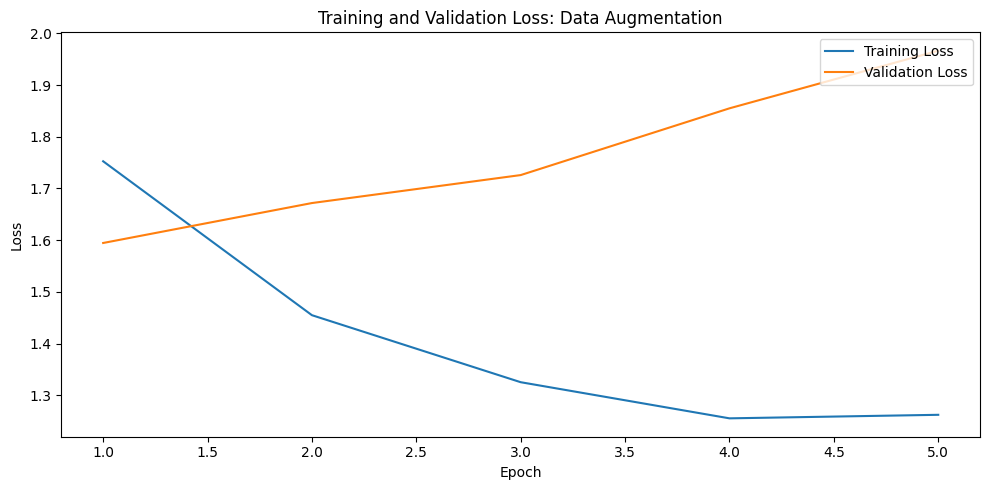

Text(0, 0.5, 'Accuracy')

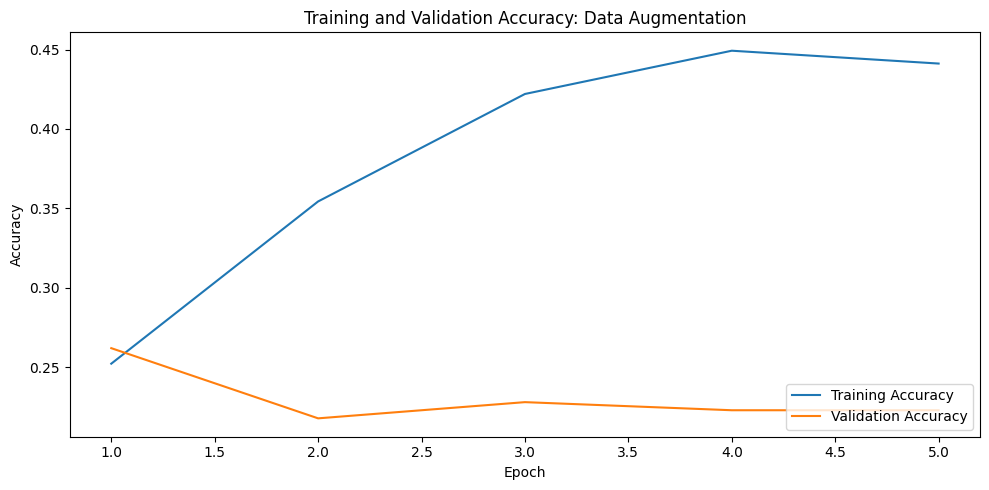

In [40]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Data Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

The training and validation behavior start to look more similar!

**Warning!** When doing data augmentation make sure augmented derivatives from the same image do not appear both in your train and validation datasets!

**Exercise:** Change some of the random transformation parameters and check if there is difference in performance.

**Exercise:** What other data augmentation techniques can be useful for this problem? Check if they are provided in [Keras](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

## Transfer Learning



Convolutional Neural Networks can be good feature extractors, i.e. a model trained on one dataset can turn out to be good at extracting useful features from another dataset. This allows deep learning methods to leverage large training sets and be able to generalize to situations where training data can be scarce.

* predict with a pretrained model on new data (zero-shot learning)
* extract features with a pretrained model and use them to train a shallow classifier on new data
* fine-tune the trained model to the new data by training with a small learning rate
* retrain the full model using the pre-trained model weights as initializers

As usual, we will have to evaluate the performance!

![TransferLearning](https://drive.google.com/uc?export=view&id=1QF9-eDrTkMouYJdU4k1qCklT3pLCI61u)

image src = https://www.slideshare.net/xavigiro/transfer-learning-d2l4-insightdcu-machine-learning-workshop-2017

![transfer_learning_chart](https://i.stack.imgur.com/RTKux.png)

### Frozen Pretrained Weights


Procedure:

* load and initialize a pretrained model
* remove the top layer
* freeze the weights of the pretrained model
* add a top layer(s) linking to our classes
* train the model

We will use a rather popular architecture VGG16 trained on the huge [Imagenet](https://www.image-net.org/) Dataset.


In [41]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
pretrained_model = VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, 3))
pretrained_model.trainable = False ## Not trainable weights

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Pretrained models have certain expectations of how the data should look like so that it can be used in the model. They have a corresponding [`preprocess_input`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) model. Make sure you read on the operations in the preprocessing so that it makes sense for your data.

In [42]:
train_images_preprocessed = preprocess_input(train_images.copy()).shape

**Warning!** The `preprocess_input` function changes the input **in-place** hence we need to pass a copy of the images.  

In [43]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    pretrained_model,
    flatten_layer,
    dense_layer_1,
    prediction_layer
])

In [44]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,037 (60.14 MB)

 Trainable params: 1,049,349 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [46]:
%%time
epochs=50
history = model.fit(
  preprocess_input(train_images.copy()),
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.6022 - loss: 5.5146 - val_accuracy: 0.6565 - val_loss: 5.0439
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7185 - loss: 4.0615 - val_accuracy: 0.6667 - val_loss: 4.8945
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.7585 - loss: 3.5770 - val_accuracy: 0.6480 - val_loss: 4.7541
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.8433 - loss: 2.1428 - val_accuracy: 0.7432 - val_loss: 3.2557
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.8680 - loss: 1.7323 - val_accuracy: 0.7789 - val_loss: 2.8555
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.8991 - loss: 1.3069 - val_accuracy: 0.7993 - val_loss: 2.6413
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.9140 - loss: 1.1148 - val_accuracy: 0.7585 - val_loss: 3.1272
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.9208 - loss: 1.0022 - val_accuracy: 0.7687 - 

* training accuracy is very high again: ~0.98
* validation accuracy is also high: 0.79

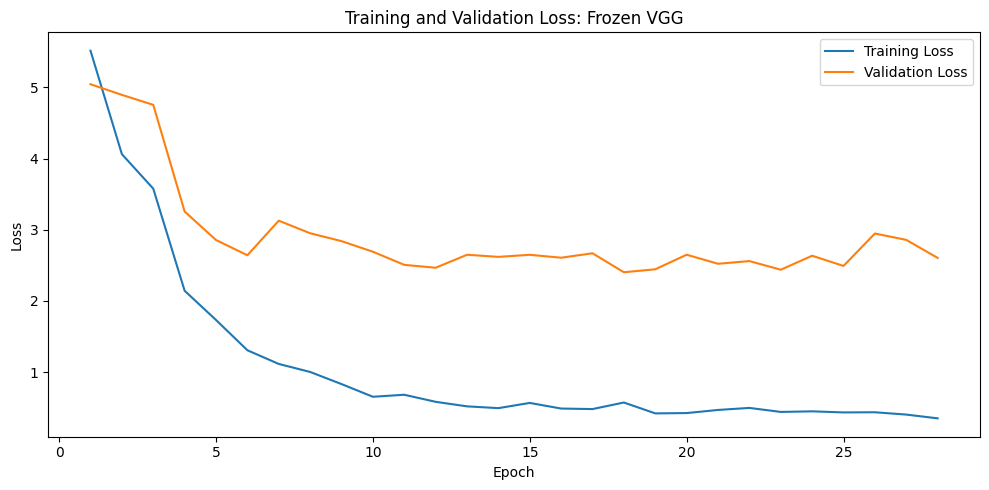

Text(0, 0.5, 'Accuracy')

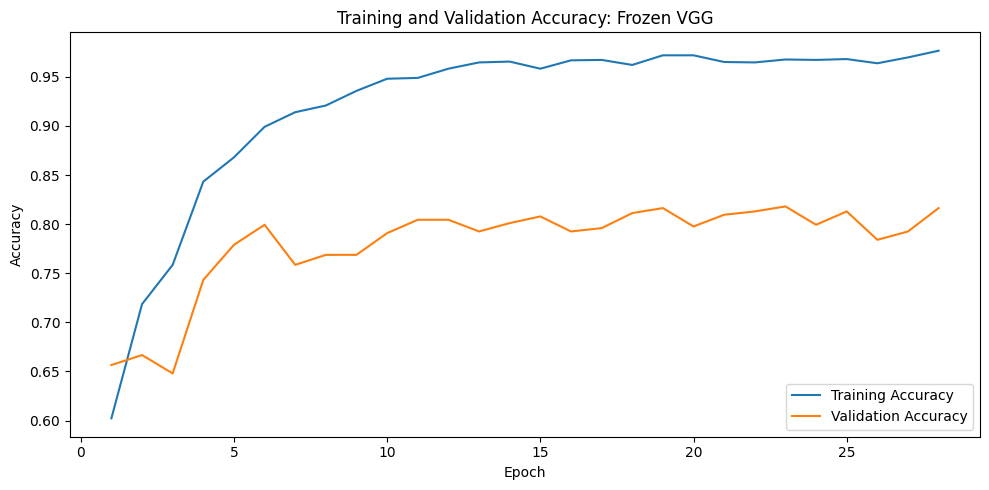

In [47]:
# accuracy metrics at each iteration are stored in the history variable
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history['loss'])+1)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Frozen VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Frozen VGG')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Fine-Tune Pretrained Weights

Fine Tuning:
* Set the pretrained model to trainable (or some of its layers)
* Compile the model again
* Retrain with a small learning rate (0.0001)


In [48]:
pretrained_model.trainable = True

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [50]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,037 (60.14 MB)

 Trainable params: 15,764,037 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
%%time
epochs=50
history_fine = model.fit(
  preprocess_input(train_images.copy()),
  train_labels,
  validation_split=0.2,
  epochs=epochs,
  batch_size=32,
  callbacks=[es]
)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 572ms/step - accuracy: 0.9710 - loss: 0.4278 - val_accuracy: 0.8384 - val_loss: 2.3237
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 568ms/step - accuracy: 0.9715 - loss: 0.4036 - val_accuracy: 0.7857 - val_loss: 2.7538
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 573ms/step - accuracy: 0.9578 - loss: 0.5077 - val_accuracy: 0.7942 - val_loss: 2.5505
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 567ms/step - accuracy: 0.9655 - loss: 0.4360 - val_accuracy: 0.7908 - val_loss: 2.5106
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 568ms/step - accuracy: 0.9672 - loss: 0.3953 - val_accuracy: 0.8027 - val_loss: 2.6407
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 567ms/step - accuracy: 0.9689 - loss: 0.3942 - val_accuracy: 0.7874 - val_loss: 2.5292
CPU times: user 9.23 s, sys: 2.39 s, total: 11.6 s
Wall time: 4min 13s


In [52]:
# accuracy metrics at each iteration are stored in the history variable

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

range(1, 35)


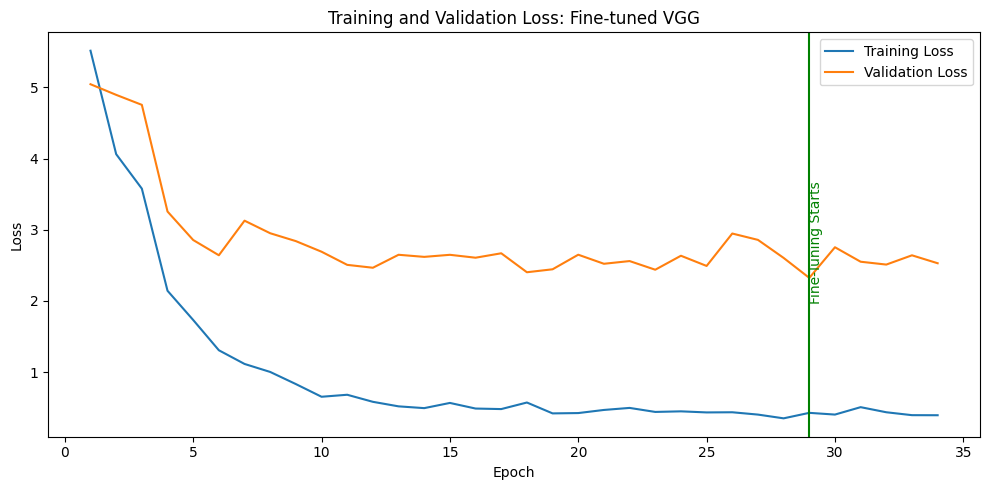

Text(0, 0.5, 'Accuracy')

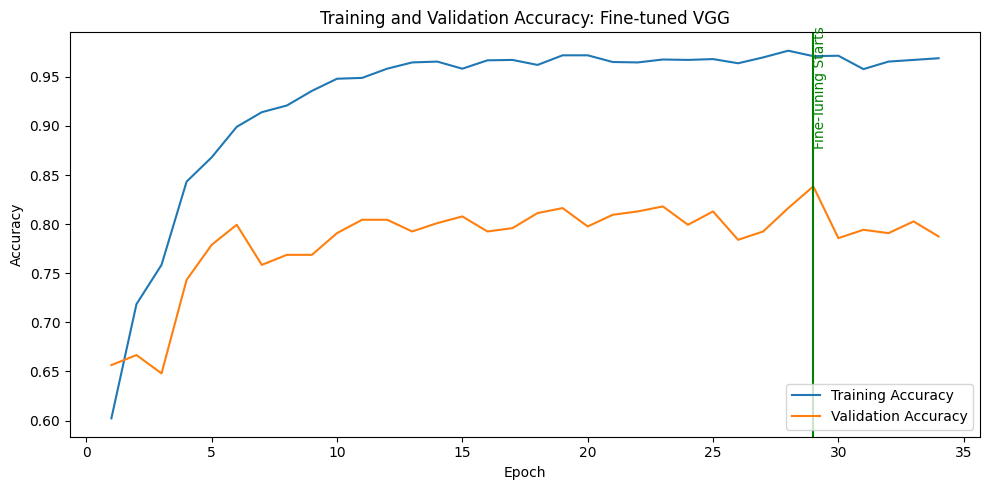

In [53]:
epochs_range = range(1, len(history.history['loss'])+ len(history_fine.history['accuracy'])+1)
print(epochs_range)

# Loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.axvline(x = len(history.history['loss'])+1, color = 'g',)
plt.text(len(history.history['loss'])+1,2,'Fine-Tuning Starts',rotation=90, color='g')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss: Fine-tuned VGG')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.axvline(x = len(history.history['loss'])+1, color = 'g')
plt.text(len(history.history['loss'])+1, 0.88,'Fine-Tuning Starts',rotation=90, color='g')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy: Fine-tuned VGG')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

**Exercise:** Retrain full model starting from the imagenet weights (making all weights trainable).

**Exercise:** Retrain the last 10 layers of the pretrained model + the top layer.
**Hint:** Use a loop to unfreeze layers.

Pretrained models can be found:
* within the [keras library](https://keras.io/api/applications/)
* on [tensorflow(kaggle) hub](https://www.tensorflow.org/hub)
* [HuggingFace](https://huggingface.co/models)
* domain-specific challenges
* colleagues


## Save Model


We are saving the model architecture, weights, and training configuration. We can restart training from it!

In [54]:
model.save("flowers_model.keras")

## Too Many Experiments!

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool to visualize experiment performance. It can also visualize results during training. There are many other options but tensorboard is open source and can run locally and integrates with notebooks.

In [55]:
# add this additional callback
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

To run tensorboard in a notebook:

In [56]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

## Hyperparameter Tuning

We can see how there are many parameters that can be tuned in a NN model:

* network parameters
* optimization parameters


A natural question is whether we can automate the process of testing different values. There are several approaches to that:

* Grid Search
* Random Search
* Bayesian Optimization

There are also tools to achieve that in Keras:

[keras tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

[HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)

**Warning!** Automatic hyperparameter search can be very prone to overtuning. It can be useful when there is a large amount of training data (which will also allow for plenty validation data). However, when large training datasets are available, the models may work well without too much tuning.

## Predict On New data

Use the selected model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [57]:
# convert to numpy arrays
test_images, test_labels = zip(*list(test_ds.unbatch()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [58]:
predictions = model.predict(test_images)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
This image most likely belongs to dandelion with a 40.46 percent confidence.


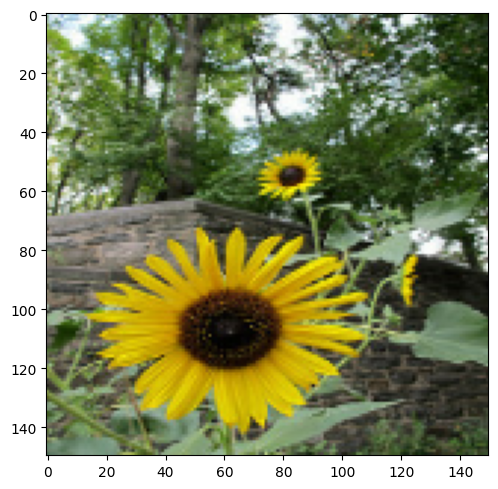

In [59]:
plt.imshow(test_images[0,:,:,:]/255.)

In [60]:
# once you are ready to evaluate on the test data you can run this command
# Warning: run this once to report the results, do not tune/select the model based on the test data!

# loss, acc = model.evaluate(test_images, test_labels)

## Go Out And Collect More Flowers!